In [1]:
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
import os
from PIL import Image
if torch.cuda.is_available():
    print(torch.cuda.device_count())
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)
import random

3
cuda:0


In [2]:
import glob
import random
import re
import json
from pathlib import Path
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
SENSORS = ["sensor{}".format(i) for i in range(1, 22)]
allsensors = random.sample(SENSORS, 4)
print(*allsensors)
allsensors.append('sensor9')

sensor17 sensor5 sensor7 sensor16


In [4]:
histwindow = 5 
batchsize = 200
testsize = 10
epochs = 300
# allsensors = ('sensor3',  'sensor4', 'sensor9','sensor14', 'sensor15')
fpath = '/proj/NARO/ghheatmap/orchid/refined_images_orchid'#ヒートマップのパス

In [5]:
xsize = histwindow * len(allsensors)

In [6]:
alldata = {}
def sensdata(name):
    jso = open("/proj/NARO/ghheatmap/orchid/sensor_data/{}/all.json".format(name))#センサのパス
    jsl = json.load(jso)
    alldata[name] = jsl
for sname in allsensors:
    sensdata(sname)

In [7]:
files = glob.glob(fpath+'/*.jpg')
sdata = []
fdata = []
tdata = []
for file in files:
    reres = re.findall('.*/data_(20\d\d)(\d\d)(\d\d)_(\d\d)(\d\d)(\d\d).jpg', file)
    (year, month, day, hour, minute, sec) = reres[0]
    dt_date = datetime(int(year), int(month), int(day), int(hour), int(minute), int(sec))
    dt_epoch = int((dt_date.timestamp()+30)/60)*60
    dt_adj = datetime.fromtimestamp(dt_epoch)
    dt_prev = dt_adj
    time_adj = dt_adj.strftime('%Y-%m-%d-%H-%M')
    time_prev = time_adj
    sensd = []
    histerr = 0
    for hist in range(0, histwindow):
        for sname in allsensors:
            if alldata[sname].get(time_prev):
                sensd.append(alldata[sname][time_prev]['Temperature'])
            else:
                histerr = 1
                break
        if histerr:
            break
        dt_prev = dt_prev - timedelta(minutes=1)
        time_prev = dt_prev.strftime('%Y-%m-%d-%H-%M')
    if not histerr:
        sdata.append(sensd)
        tdata.append(time_adj)
        fdata.append(file)

In [8]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        self.data_num = len(tdata)
    def __len__(self):
        return self.data_num
    def __getitem__(self, idx):
        image = Image.open(fdata[idx])
#        if self.transform:
#            out_data = self.transform(image)
        out_data = np.array(image).reshape(16*18).astype(np.int32) 
        out_data = out_data*50/255
        return torch.Tensor(sdata[idx]), torch.Tensor(out_data) 
data_set = MyDataset()
print(len(data_set))

1109


In [9]:
def heatmapshow(data):
    im = Image.fromarray(data[0].numpy().reshape([16,18]).copy()*255/50)
    fig, ax = plt.subplots()
    ax.imshow(im, cmap="gray")
    plt.show()

In [10]:
train_size = len(data_set)*0.8
train_size

887.2

In [11]:
from torch.utils.data.dataset import Subset
def split_dataset(data_set, split_at, order=None):
    from torch.utils.data.dataset import Subset
    n_examples = len(data_set)
    if split_at < 0:
        raise ValueError('split_at must be non-negative')
    if split_at > n_examples:
        raise ValueError('split_at exceeds the dataset size')
    if order is not None:
        subset1_indices = order[0:split_at]
        subset2_indices = order[split_at:n_examples]
    else:
        subset1_indices = list(range(0,split_at))
        subset2_indices = list(range(split_at,n_examples))

    subset1 = Subset(data_set, subset1_indices)
    subset2 = Subset(data_set, subset2_indices)
    return subset1, subset2

def split_dataset_random(data_set, first_size, seed=0):
    order = np.random.RandomState(seed).permutation(len(data_set))
    return split_dataset(data_set, int(first_size), order)

In [12]:
test_dataset, data_set = split_dataset_random(data_set, 10, seed=0)
val_dataset, train_dataset = split_dataset_random(data_set, 10, seed=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
train_loader = DataLoader(dataset=data_set, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(dataset=data_set, batch_size=batchsize, shuffle=False)
print(len(test_dataset), len(train_dataset), len(val_dataset))

10 1089 10


In [13]:
class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.fc1 = nn.Linear(xsize, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 16*18)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
model = NET().to(device)
model

NET(
  (fc1): Linear(in_features=25, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=288, bias=True)
)

In [14]:
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
train_loss_list = []
val_loss_list = []
t1 = time.time()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(epochs):
    model.train()
    train_running_loss = 0
    for batch_idx, (x, c) in enumerate(train_loader):
        x = x.to(device)
        c = c.to(device)
        optimizer.zero_grad()
        y = model(x)
        train_loss = criterion(y, c)
        train_running_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
    train_loss_list.append(train_loss)
    train_loss = train_running_loss / len(train_loader) 
    
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for batch_idx, (x, c) in enumerate(val_loader):
            x = x.to(device)
            c = c.to(device)
            y = model(x)
            val_loss = criterion(y, c)
            val_running_loss += val_loss.item()
        val_loss_list.append(val_loss)

    if epoch == 0:
        best_epoch = epoch
        torch.save(model.state_dict(), 'model.pth')
        best_valid_loss = val_running_loss
    else:
        if best_valid_loss > val_running_loss:
            torch.save(model.state_dict(), f"model{epoch}.pth")
            best_valid_loss = val_running_loss
            best_epoch = epoch

    val_loss = val_running_loss / len(val_loader)  
    print('epoch %d, loss: %.4f val_loss: %.4f' % (epoch, train_loss, val_loss))
    
    
print('best_epoch', best_epoch)
t2 = time.time()
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

epoch 0, loss: 557.2514 val_loss: 460.0567
epoch 1, loss: 467.1637 val_loss: 419.8491
epoch 2, loss: 248.1324 val_loss: 74.6428
epoch 3, loss: 67.5698 val_loss: 74.8655
epoch 4, loss: 44.5371 val_loss: 51.9370
epoch 5, loss: 31.3577 val_loss: 31.2434
epoch 6, loss: 18.4619 val_loss: 22.3088
epoch 7, loss: 14.7107 val_loss: 14.5021
epoch 8, loss: 10.6501 val_loss: 10.9915
epoch 9, loss: 9.7983 val_loss: 9.0562
epoch 10, loss: 9.2540 val_loss: 8.0847
epoch 11, loss: 8.8054 val_loss: 8.3912
epoch 12, loss: 8.1976 val_loss: 8.4135
epoch 13, loss: 7.7672 val_loss: 8.6353
epoch 14, loss: 7.7772 val_loss: 7.6493
epoch 15, loss: 7.2155 val_loss: 7.2109
epoch 16, loss: 7.2498 val_loss: 7.1283
epoch 17, loss: 7.0880 val_loss: 7.2065
epoch 18, loss: 6.8383 val_loss: 6.7136
epoch 19, loss: 6.6287 val_loss: 6.5606
epoch 20, loss: 6.4105 val_loss: 6.3467
epoch 21, loss: 6.2477 val_loss: 6.1575
epoch 22, loss: 5.9116 val_loss: 5.9893
epoch 23, loss: 5.8204 val_loss: 5.9881
epoch 24, loss: 5.8231 val_

epoch 202, loss: 0.2933 val_loss: 0.2815
epoch 203, loss: 0.3412 val_loss: 0.3011
epoch 204, loss: 0.2970 val_loss: 0.2776
epoch 205, loss: 0.2828 val_loss: 0.2859
epoch 206, loss: 0.2761 val_loss: 0.2668
epoch 207, loss: 0.2727 val_loss: 0.3025
epoch 208, loss: 0.2857 val_loss: 0.2696
epoch 209, loss: 0.2617 val_loss: 0.2542
epoch 210, loss: 0.2588 val_loss: 0.2568
epoch 211, loss: 0.2562 val_loss: 0.2483
epoch 212, loss: 0.2490 val_loss: 0.2459
epoch 213, loss: 0.2502 val_loss: 0.3187
epoch 214, loss: 0.2650 val_loss: 0.2426
epoch 215, loss: 0.2401 val_loss: 0.2464
epoch 216, loss: 0.2499 val_loss: 0.2398
epoch 217, loss: 0.2567 val_loss: 0.2316
epoch 218, loss: 0.2333 val_loss: 0.2311
epoch 219, loss: 0.2420 val_loss: 0.2279
epoch 220, loss: 0.2245 val_loss: 0.2320
epoch 221, loss: 0.2310 val_loss: 0.2199
epoch 222, loss: 0.2223 val_loss: 0.2370
epoch 223, loss: 0.2362 val_loss: 0.2150
epoch 224, loss: 0.2232 val_loss: 0.2229
epoch 225, loss: 0.2295 val_loss: 0.2116
epoch 226, loss:

In [16]:
test_net = NET().to(device)
test_net.eval()
test_net.load_state_dict(torch.load('model' + str(best_epoch) + '.pth'))

<All keys matched successfully>

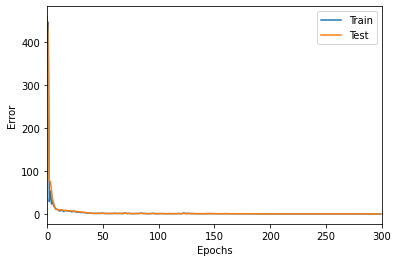

In [17]:
train_loss_list = torch.tensor(train_loss_list)
val_loss_list = torch.tensor(val_loss_list)

plt.xlim(0, epochs)
plt.plot(range(len(train_loss_list)), train_loss_list, label="Train")
plt.plot(range(len(val_loss_list)), val_loss_list, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [18]:
import seaborn
def test():
    test_net.eval()
    running_loss = 0
    with torch.no_grad():
        total_max_temp_error = 0
        total_min_temp_error = 0
        max_error_x = 0
        max_error_y = 0
        min_error_x = 0
        min_error_y = 0
        error_per_pix = 0
        loss_sum = 0
        max_error_x_abs = 0
        max_error_y_abs = 0
        min_error_x_abs = 0
        min_error_y_abs = 0
            
        estimate_list = []

        for batch_idx, (x, c) in enumerate(test_loader):
            estimate_start = time.time()
            x = x.to(device)
            c = c.to(device)
            y = model(x)
            estimate_end = time.time()
            estimate_duration = -estimate_start+estimate_end
#             print("{}個目のモデルの推定時間は：{}秒です".format(batch_idx+1, estimate_duration))
            estimate_list.append(estimate_duration)
            loss = criterion(y, c)
            loss_unit = torch.sum(torch.abs(y-c))/16/18
            loss_sum = loss_sum + loss_unit
            running_loss += loss.item()
            
            
            y = y.cpu()
            c = c.cpu()
            c_reshaped = c.reshape(16, 18)
            seaborn.heatmap(c_reshaped, vmin=18, vmax=25)
            plt.show()
            y_reshaped = y.reshape(16, 18)
            seaborn.heatmap(y_reshaped, vmin=18, vmax=25)
            plt.show()
            print('==================')
            
            #最高温度のずれ
            max_temp_output = torch.max(c)
            max_temp_target = torch.max(y)
            max_temp_error = max_temp_output - max_temp_target
            total_max_temp_error = total_max_temp_error + max_temp_error

            #最低温度のずれ
            min_temp_output = torch.min(c)
            min_temp_target = torch.min(y)
            min_temp_error = min_temp_output - min_temp_target
            total_min_temp_error = total_min_temp_error + min_temp_error

            #最高温度を示すピクセルの座標のずれ(絶対値)
            max_temp_arg = torch.argmax(c)
            max_x_output = (max_temp_arg + 1)%18 -1
            max_y_output = -(max_temp_arg + 1)//18

            max_temp_arg = torch.argmax(y)
            max_x_target = (max_temp_arg + 1)%18 -1
            max_y_target = -(max_temp_arg + 1)//18
            
            max_error_x = max_error_x + abs(max_x_output - max_x_target)
            max_error_y = max_error_y + abs(max_y_output - max_y_target)

            # 最低温度を示すピクセルの座標のずれ(絶対値)
            min_temp_arg = torch.argmin(c)
            min_x_output = (min_temp_arg + 1)%18 -1
            min_y_output = -(min_temp_arg + 1)//18

            min_temp_arg = torch.argmin(y)
            min_x_target = (min_temp_arg + 1)%18 -1
            min_y_target = -(min_temp_arg + 1)//18
            
            min_error_x = min_error_x + abs(min_x_output - min_x_target)
            min_error_y = min_error_y + abs(min_y_output - min_y_target)

    print("平均時間は{}秒です".format(sum(estimate_list)/len(estimate_list)))

    print('1ピクセルあたりの誤差', loss_sum/len(test_loader))
    print('最高温度のずれ', total_max_temp_error/len(test_loader))      
    print('最低温度のずれ', total_min_temp_error/len(test_loader))
    print('最高温度を示すピクセルの座標のずれ', max_error_x_abs/len(test_loader), max_error_y_abs/len(test_loader), )
    print('最低温度を示すピクセルの座標のずれ', min_error_x_abs/len(test_loader), min_error_y_abs/len(test_loader), )
    
    print("batch_size: {}　です。頑張ってください".format(batchsize))
    print(fpath)
    p = [loss_sum/len(test_loader), total_max_temp_error/len(test_loader), total_min_temp_error/len(test_loader), max_error_x/len(test_loader), max_error_y/len(test_loader), min_error_x/len(test_loader), min_error_y/len(test_loader), max_error_x_abs/len(test_loader), max_error_y_abs/len(test_loader), min_error_x_abs/len(test_loader), min_error_y_abs/len(test_loader), best_epoch]
    p = [float(x) for x in p]
    p.insert(0, histwindow)
    print(*p, sep=', ')

    val_loss = running_loss / len(test_loader)

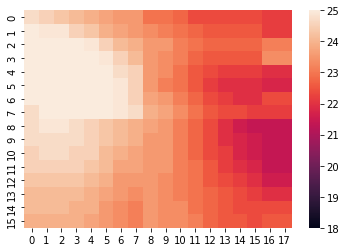

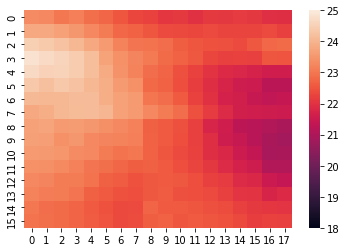

/tmp/ipykernel_44899/3888301556.py:61: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_y_output = -(max_temp_arg + 1)//18
/tmp/ipykernel_44899/3888301556.py:65: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_y_target = -(max_temp_arg + 1)//18
/tmp/ipykernel_44899/3888301556.py:73: UserWarning: __floordiv__ is deprecated, and its 

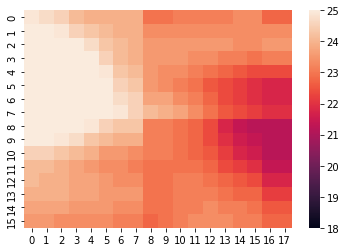

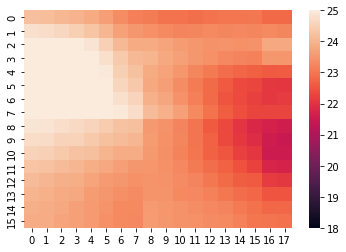

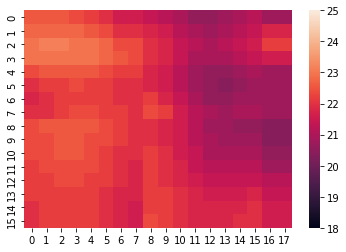

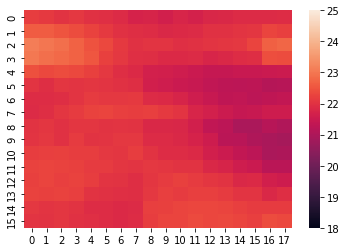

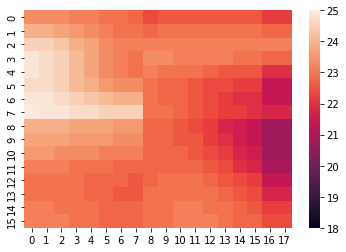

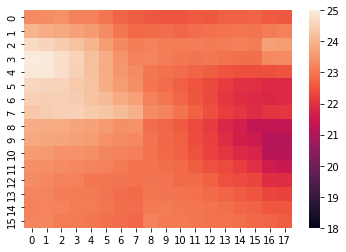

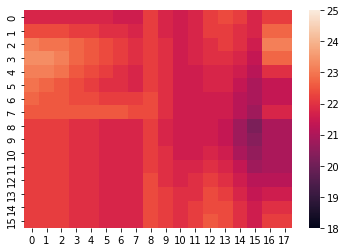

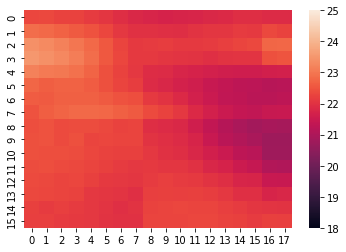

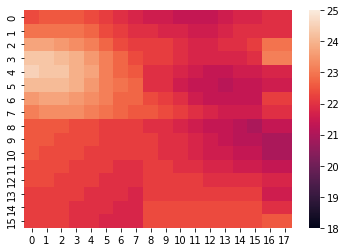

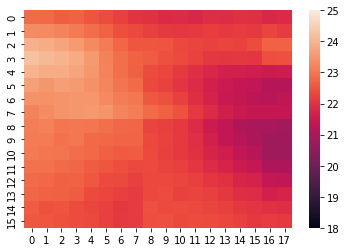

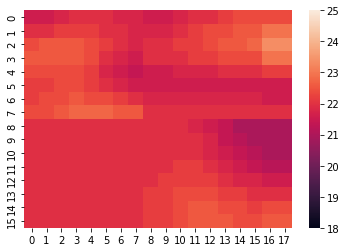

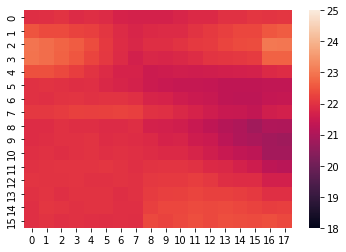

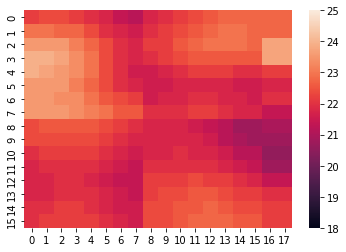

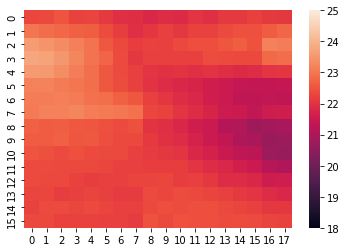

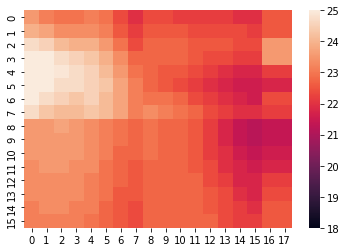

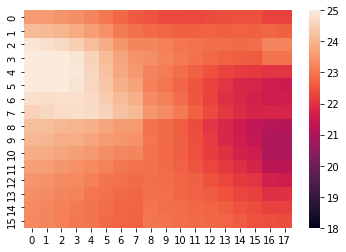

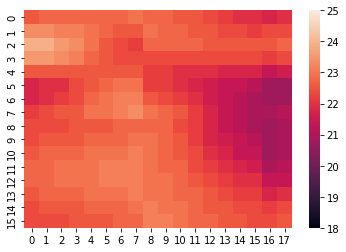

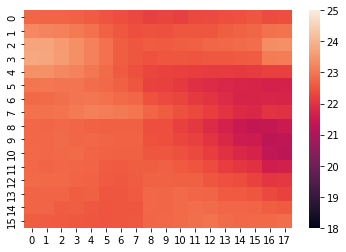

平均時間は0.0006231307983398437秒です
1ピクセルあたりの誤差 tensor(0.3112, device='cuda:0')
最高温度のずれ tensor(0.2871)
最低温度のずれ tensor(-0.1098)
最高温度を示すピクセルの座標のずれ 0.0 0.0
最低温度を示すピクセルの座標のずれ 0.0 0.0
batch_size: 200　です。頑張ってください
/proj/NARO/ghheatmap/orchid/refined_images_orchid
5, 0.31120187044143677, 0.28709298372268677, -0.1097843199968338, 0.20000000298023224, 0.8999999761581421, 16.0, 2.5999999046325684, 0.0, 0.0, 0.0, 0.0, 297.0
17 : 5 : 7 : 16 : 9


In [19]:
test()
print(allsensors[0][6:] + ' : '  + allsensors[1][6:] + ' : ' + allsensors[2][6:] + ' : '  + allsensors[3][6:] + ' : ' + allsensors[4][6:])